<a href="https://colab.research.google.com/github/emarttila/Koodausnaytteet/blob/main/Koneoppiminen_ja_datan_analysointi_(Student_Performance_dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Aineistona on portugalilaisen koulun oppilailta kerättyjä tietoja. Kerättyjen tietojen yhteyttä oppilaiden loppuarvosanaan matematiikassa (G3) pyrittiin hahmottamaan ja ennustamaan. Mukana ovat myös väliarvosanat G1 ja G2.**


*P. Cortez and A. Silva. Using Data Mining to Predict Secondary School Student Performance. In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7. *

Tuodaan tarvittavat kirjastot.

In [101]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

Avataan aineisto.

In [102]:
dataset = pd.read_csv("student-mat.csv", sep = ';')

Tarkastellaan muuttujien tyyppiä.

In [103]:
print(dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

Katsotaan onko aineistossa puuttuvia arvoja (ei ole).

In [104]:
dataset.isnull().sum().sum()

0

Muutetaan objekti- datatyypit kategorioiksi.

In [105]:
for i in dataset.columns:
  if dataset[i].dtype == 'O':
    dataset[i] = dataset[i].astype('category')
kategoriat = dataset.select_dtypes(include=['category'])

Datatyypit ovat kunnossa. Järjestysasteikolliset ja diskreetit muuttujat ovat 'int64'- ja luokitteluasteikolliset 'category' - datatyyppiä. Jostakin syystä osasta jatkuvista muuttujista on datassa tehty järjestysasteikollisia.

In [106]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      395 non-null    category
 1   sex         395 non-null    category
 2   age         395 non-null    int64   
 3   address     395 non-null    category
 4   famsize     395 non-null    category
 5   Pstatus     395 non-null    category
 6   Medu        395 non-null    int64   
 7   Fedu        395 non-null    int64   
 8   Mjob        395 non-null    category
 9   Fjob        395 non-null    category
 10  reason      395 non-null    category
 11  guardian    395 non-null    category
 12  traveltime  395 non-null    int64   
 13  studytime   395 non-null    int64   
 14  failures    395 non-null    int64   
 15  schoolsup   395 non-null    category
 16  famsup      395 non-null    category
 17  paid        395 non-null    category
 18  activities  395 non-null    category
 19  nursery 

In [107]:
feature_names = ['G3']
Q1=[]
Q3=[]
IQR=[]
#Calculate Q1, Q3 and IQR for each feature:
for i, j in enumerate(feature_names):
    Q1.append(dataset[j].quantile(.25))
    Q3.append(dataset[j].quantile(.75))
    IQR.append(Q3[i]-Q1[i])
# Drop outliers:
for i, j in enumerate(feature_names):
    true_index = (dataset[j] >= (Q1[i] - 2 * IQR[i])) & (dataset[j] <=(Q3[i] + 2 * IQR[i]))
    dataset = dataset.loc[true_index] 

Katsotaan muuttujien kuvauksia.

In [108]:
print(dataset.describe(include=['category'] ))
print(dataset.describe())

       school  sex address famsize  ... nursery higher internet romantic
count     395  395     395     395  ...     395    395      395      395
unique      2    2       2       2  ...       2      2        2        2
top        GP    F       U     GT3  ...     yes    yes      yes       no
freq      349  208     307     281  ...     314    375      329      263

[4 rows x 17 columns]
              age        Medu        Fedu  ...          G1          G2          G3
count  395.000000  395.000000  395.000000  ...  395.000000  395.000000  395.000000
mean    16.696203    2.749367    2.521519  ...   10.908861   10.713924   10.415190
std      1.276043    1.094735    1.088201  ...    3.319195    3.761505    4.581443
min     15.000000    0.000000    0.000000  ...    3.000000    0.000000    0.000000
25%     16.000000    2.000000    2.000000  ...    8.000000    9.000000    8.000000
50%     17.000000    3.000000    2.000000  ...   11.000000   11.000000   11.000000
75%     18.000000    4.000000  

Tarkastellaan 'G3':n eli loppukokeen arvosanan jakaumaa. Jakauma näyttää muuten symmetriseltä, mutta arvoja 0 näyttää olevan enemmän kuin olettaisi. 0-arvojen poistaminen outliereina kuitenkin huonontaa koneoppimisen mallia huomattavasti silloin, kun väliarvosanat eivät ole mukana mallin teossa. Väliarvosanojen ollessa mukana mallin ennustus tarkentuu. 0-arvot voisi poistaa, mutta ne jätetään, koska mallin ennustus ilman väliarvosanoja on mielekkäämpää pitää tarkempana.

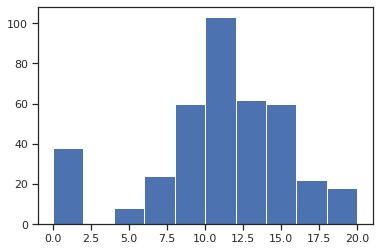

In [109]:
plt.hist(dataset['G3'])
plt.show()

Etsitään univariate outliereita. Valittiin tähän muuttujat, jotka ovat jatkuvia. Järjestysasteikolliset ja muut diskreetit muuttujat jätettiin pois. Outliereita näyttäisi olevan IQR:llä arvioituna 'failures' ja 'absences' muuttujissa. Kuitenkin jos ne poistetaan, niin koneoppimisen mallin ennustuksen tarkkuus huononee. Koska poistaminen ei paranna mallin tarkkuutta, outlierit jätetään dataan.

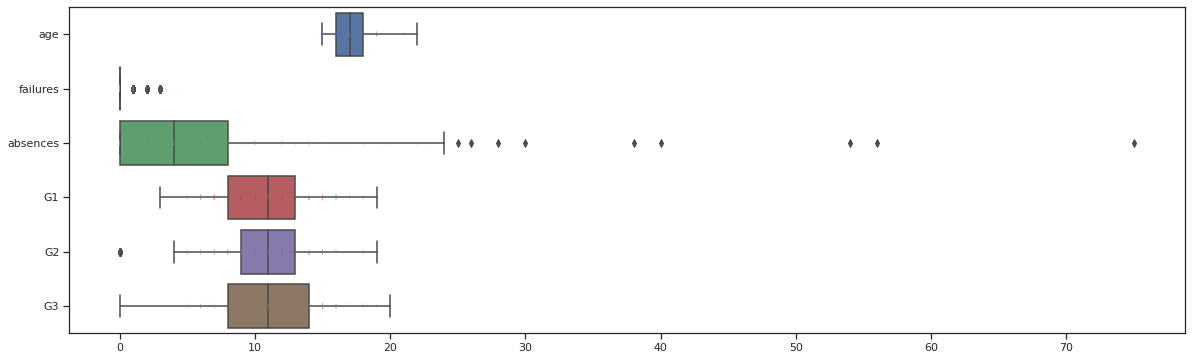

In [110]:
fig_dims = (20,6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(data= dataset.iloc[:,[2,14,29,30,31,32]],orient = "h", whis =2)
ax = sns.stripplot(data=dataset.iloc[:,[2,14,29,30,31,32]],orient = 'h', jitter=0.05,size = 1, alpha = 0.2 )

plt.show()

Tarkastellaan lineaarista riippuvuutta muuttujien ja G3:n eli lopullisen arvosanan kanssa. 

In [111]:
korrelaatio = dataset.corr()
korrelaatio['G3'].sort_values(ascending=False)

G3            1.000000
G2            0.904868
G1            0.801468
Medu          0.217147
Fedu          0.152457
studytime     0.097820
famrel        0.051363
absences      0.034247
freetime      0.011307
Walc         -0.051939
Dalc         -0.054660
health       -0.061335
traveltime   -0.117142
goout        -0.132791
age          -0.161579
failures     -0.360415
Name: G3, dtype: float64

Lineaariset riippuvuudet kaikkien jatkuvien muuttujien välillä.

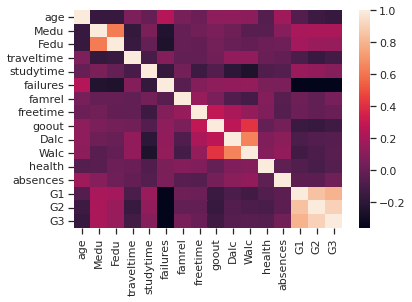

In [112]:
sns_plot = sns.heatmap(dataset.corr())

Epälineaaristen riippuvuuksien tarkastelu. Mitään merkittävää epälineaarista riippuvuutta ei näy.

In [ ]:
counter = 0
fig, ax = plt.subplots(3,5, figsize = (40,20))
for i in range(3):
    for j in range(5):
        x = dataset[korrelaatio.columns[counter]]
        ax[i, j].bar(x,dataset['G3'])
        ax[i, j].set_ylabel('G3',fontsize=20)
        ax[i, j].set_xlabel(str(korrelaatio.columns[counter]),fontsize=20)
        counter += 1

Valitaan aineistosta muuttujat, joiden korrelaation itseisarvo G3:n eli lopullisen arvosanan kanssa on vähintään 0,09. G2 ja G1 jätetään pois, koska ne ovat väliarvosanoja ja niillä on suuri vaikutus lopulliseen arvosanaan. Piirretään kuvaajaan jokainen muuttuja ja sen yhteys G3:n.

In [ ]:
sns.set(font_scale=2)
sns.set_style('darkgrid')
f, ax = plt.subplots(3,3, figsize = (36,18), sharex=False, sharey=False)
failures = sns.violinplot(dataset['failures'], dataset['G3'], ax=ax[0][0])
failures.set_xlabel('Past class failures')
Medu = sns.violinplot(dataset['Medu'], dataset['G3'], ax=ax[0][1])
Medu.set_xlabel('Mothers education level')
Medu.set_xticklabels(['None','4th grade','5-9th grade','Secondary','Higher'], fontsize = 19)
age = sns.violinplot(dataset['age'], dataset['G3'], ax=ax[0][2])
age.set_xlabel('Age')
Fedu = sns.violinplot(dataset['Fedu'], dataset['G3'], ax=ax[1][0])
Fedu.set_xlabel('Fathers education level')
Fedu.set_xticklabels(['None','4th grade','5-9th grade','Secondary','Higher'], fontsize = 19)
goout = sns.violinplot(dataset['goout'], dataset['G3'], ax=ax[1][1])
goout.set_xlabel('How much going out with friends')
goout.set_xticklabels(['Very low','Low','Average','High','Very high'])
traveltime = sns.violinplot(dataset['traveltime'], dataset['G3'], ax=ax[1][2])
traveltime.set_xlabel('Home to school travel time')
traveltime.set_xticklabels(['<15 min','15 to 30 min','30 min to 1 hour','>1 hour'], fontsize = 19)
studytime = sns.violinplot(dataset['studytime'], dataset['G3'], ax=ax[2][0])
studytime.set_xlabel('Weekly study time')
studytime.set_xticklabels(['<2 hours','2 to 5 hours','5 to 10 hours','>10 hours'], fontsize = 19)
for i in [7,8]:
  f.delaxes(ax.flatten()[i])


Kuvaajasta näkee, että 'Past class failures' korreloi negatiivisesti matematiikan arvosanan kanssa. Isän ja äidin koulutustason korrelaatio matematiikan arvosanaan on ristiriitainen. Kaikista matalin koulutustaso ennustaa parempaa arvosanaa kuin seuraavaksi korkein. Siitä lähtien kuitenkin koulutustason paraneminen korreloi positiivisesti arvosanan kanssa. Oppilaan ikä korreloi negatiivisesti arvosanan kanssa, paitsi 20:s ikävuosi, jolloin korrelaatio kääntyy positiiviseksi. Ystävien kanssa vietetty aika korreloi negatiivisesti arvosanan kanssa. Negatiivinen korrelaatio voimistuu mitä enemmän ystävien kanssa vietetty aika kasvaa. Mitä pidempi koulumatka, sen huonompi arvosana. Viikottainen opiskeluaika on yllättävän vähän yhteydessä arvosanaan. Kuitenkin mitä enemmän opiskelee, sen parempi kokeen tulos. Hajonta on kuitenkin suurta varsinkin eniten opiskelevien ryhmässä.

Vertaillaan seuraavaksi aineiston kahta eri koulua loppuarvosanan G3 suhteen. 

In [ ]:
sns.set(font_scale=1)
sns.set_style('ticks')
grid = sns.FacetGrid(dataset, row='school', hue = 'school', sharey=False,  aspect=1.4, size = 3)
grid.map(sns.distplot, 'G3')
grid.set(xlim=(0,20)) 
grid.map(lambda x, **kw: plt.axvline(x.median(), color='r'), 'G3')

Kuvia vertaamalla nähdään, että koulussa GP saadaan parempia arvosanoja matematiikassa. Kuvassa oleva pystysuora viiva on matematiikan kokeen tuloksen mediaani.

*school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)*

Katsotaan vielä, miten opiskeluun käytetty aika eri koulujen välillä vaikuttaa G3:een.

In [ ]:
sns.set(font_scale=1)
sns.set_style('ticks')
grid = sns.FacetGrid(dataset,col= 'studytime', row='school', hue = 'school', sharey=False,  aspect=1.4, size = 3)
grid.map(sns.distplot, 'G3')
grid.set(xlim=(0,20)) 
grid.map(lambda x, **kw: plt.axvline(x.median(), color='r'), 'G3')

Kuvista nähdään, että sama opiskeluun käytetty aika tuottaa koulussa GP parempia tuloksia, kuin koulussa MS. Ero on suurin ryhmässä, joka käyttää vähiten aikaa opiskeluun ja tasoittuu mitä enemmän käytetään aikaa opiskeluun. Koulussa MS kukaan ei käytä yli 10 tuntia viikossa opiskeluun, toisin kuin koulussa GP. Kuvien pystysuora viiva on G3:n mediaani.

*studytime - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)* 

*school - student's school (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)* 

Tehdään seuraavaksi XGBoostilla regressiomalli, jonka avulla pyritään ennustamaan loppukokeen tulosta muiden muuttujien pohjalta. Jätetään aluksi G1 ja G2 pois, koska ne ovat väliarvosanoja ja vaikuttavat selvästi G3:n. Jaetaan aineisto riippumattomiin ja riippuvaan muuttujaan, koodataan kategoriset muuttujat OneHotEncoderilla, jaetaan riippumattomat muuttujat training settiin ja test settiin, tehdään regressiomalli training setin pohjalta ja testataan sen tarkkuus test setillä. Arvioidaan ennustuksen tarkkuutta r2 testillä.

Jaetaan aineisto riippumattomiin ja riippuvaan muuttujaa. Jätetään G1 ja G2 eli väliarvosanat pois kokonaan.


In [ ]:
X = dataset.iloc[:, :-3].values
y = dataset.iloc[:, -1].values

Koodataan kategoriset muuttujat OneHotEncoderilla.


In [ ]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

Jaetaan havainnot training ja test settiin.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

Käytetään XGBoostia regressiomallin luomiseen ja loppukokeen tuloksen ennustamiseen.

In [ ]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)

Taulukoidaan vierekkäin ennustettu ja testisetin todellinen arvo.


In [ ]:
y_pred = regressor.predict(X_test)
np.set_printoptions(precision=0)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

Katsotaan ennustuksen tarkkuus R2 testillä. Heikolta näyttää. Entä jos väliarvosanat ovat mukana?


In [ ]:
r2_score(y_test,y_pred)

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0,1,3,4,5,8,9,10,11,15,16,17,18,19,20,21,22])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
regressor = xgb.XGBRegressor()
regressor.fit(X_train, y_train)

In [ ]:
y_pred = regressor.predict(X_test)

Jos väliarvosanat otetaan mukaan, niin mallin ennustuksen tarkkuus paranee huimasti.


In [ ]:
r2_score(y_test,y_pred)